# HoxHunt Summer Hunters 2020 - Data - Home assignment


<img src="https://www.dropbox.com/s/zmuij2fyjo27j1u/Screenshot%202019-03-21%2017.28.10.png?dl=1" width="1000">

## Assignment

In this assignment you as a HoxHunt Data Science Hunter are given the task to extract interesting features from a possible malicious indicator of compromise, more specifically in this case from a given potentially malicious URL. 

<img src="https://www.dropbox.com/s/ao0neaphtfama7g/Screenshot%202019-03-21%2017.23.40.png?dl=1" width="400">

This assignment assumes that you are comfortable (or quick to learn) on using Jupyter Notebooks and suitable programming enviroment such as Python, R or Julia. The example below uses Python and has some external dependencies such as Requests library.

Happy hunting!


## Interesting research papers & resources

Below is a list of interesting research papers on the topic. They might give you good tips what features you could extract from a given URL:


[Know Your Phish: Novel Techniques for Detecting
Phishing Sites and their Targets](https://arxiv.org/pdf/1510.06501.pdf)

[DeltaPhish: Detecting Phishing Webpages
in Compromised Websites](https://arxiv.org/pdf/1707.00317.pdf)

[PhishAri: Automatic Realtime Phishing Detection on Twitter](https://arxiv.org/pdf/1301.6899.pdf)

[More or Less? Predict the Social Influence of Malicious URLs on Social Media
](https://arxiv.org/abs/1812.02978)

[awesome-threat-intelligence](https://github.com/hslatman/awesome-threat-intelligence)



## What we expect

Investigate potential features you could extract from the given URL and implement extractors for the ones that interest you the most. Below example code extracts one feature but does not store it very efficiently (just console logs it). Implement sensible data structure using some known data structure library to store the features per URL. Also consider how would you approach error handling if one feature extractor fails?

Be prepared to discuss questions such as: what features could indicate the malicousness of a given URL? What goes in to the thinking of the attacker when they are choosing a site for an attack? What would you develop next?

## What we don't expect

Implement a humangous set of features.

Implement any kind of actual predicition models that uses the features to give predictions on malicousness at this stage :) 

## My first thoughts


Feature engineering is very much about creativity, hence I think it is very valuable when starting to work on a new problem to first try creating features on your own for a few days before diving into other people's approaches or papers. I think seeing how other people have solved a problem before very much steers your thinking into that direction unconsiously. 

### Type of features that come to mind
I can think of a few different types of features one could use for phising url detection:
    1. URL based
        - Just use the text string of the url to compute things such as url length etc.
    2. Page content based
        - Get the html file and analyze the page structure for example "is the metadata field filled?"
    3. Domain based
        - When was the domain registered?
        - To which country it was registered to?

I will mostly focus on the URL based features as if you could make a model work with them I think it would be the best case scenario as the computation is much lighter and we could use the already closed phising domain urls as our data.

## Journal
    - 21.02 Read the problem, understand what its about and start generating features relying solely on own experience and intuition.
    
    - 22.02 Beer

    - 23.02 Start reading papers for more ideas. Implement Random forests for the academic phising dataset.
    
    - 24.02 Generate more features. TFIDF as the top performing revelation.
    
    - 25.02 Finalize the project


### Imports

In [1]:
import requests
import json
import pandas as pd
from urllib.parse import urlparse
import re
import tldextract as tlde
import warnings
warnings.filterwarnings('ignore') # Added to suppress useless warnings.
from string import punctuation

In [2]:
def get_domain_age_in_days(domain):
    "Returns the domain age in days by querying an API. If the request fails, returns the error as a string"
    show =  "https://input.payapi.io/v1/api/fraud/domain/age/" + domain
    try:
        r = requests.get(show)
        r.raise_for_status()
        data = r.json()
        return data['result'] if 'result' in data else None
    except requests.exceptions.RequestException as e:  
        return str(e).split(':')[0]
    
    
# https://ip-api.com/ is a free geolocation API
def get_hosting_country(domain):
    "Returns the domain hosting country by querying an API. If the request fails, returns the error as a string"
    show = "http://ip-api.com/json/" + domain
    try:
        r = requests.get(show)
        r.raise_for_status()
        data = r.json()
        return data['country'] if data['status'] == 'success' else data['message']
    except requests.exceptions.RequestException as e:  
        return str(e).split(':')[0]
    
def get_org_field(domain):
    "Returns the organization that has registered the domain by querying an API. If the request fails, returns the error as a string"
    show = "http://ip-api.com/json/" + domain
    try:
        r = requests.get(show)
        r.raise_for_status()
        data = r.json()
        return data['org'] if data['status'] == 'success' else data['message']
    except requests.exceptions.RequestException as e:  
        return str(e).split(':')[0]
    
def parse_domain_from_url(url):
    "Returns the domain part of an url."
    t = urlparse(url).netloc
    return '.'.join(t.split('.')[-2:])

def remove_prefix(text, prefix):
    "Removes prefix from a string. Returns the string without the prefix"
    return text[len(prefix):] if text.startswith(prefix) else text

def clean_up_url(url):
    "Removes http:// or https:// prefix from an string. Returns the string without the prefix"
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        url = remove_prefix(url, prefix)
    return url

def n_non_alphanumerics(string):
    "Returns the number of non alphanumeric chars in a string"
    return len([char for char in string if not char.isalpha()])

#https://www.researchgate.net/publication/333166694_Phishing_URL_detection_system_based_on_URL_features_using_SVM
def n_suspicous_chars(string):
    "Returns the number of special characters (!#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~) in a string"
    return len([char for char in string if char in punctuation])

# https://www.wandera.com/top-10-mobile-phishing-techniques/
def top_misspelled(domain):
    "Returns whether an url contains misspelled words"
    top_misspelled = ['apple-com', 'applecom', 'apple.con', 'appie.com',  'app-le.com',
                      'pavpal.com', 'puaypal.com', 'pauypal.com', 'paypal-com', 'paypai.com',
                      'wellsf.argo.com', 'Iclod.com', 'icloud-com', '1cloud.com', 'lcloud.com',
                      'apple-id', 'apple.id', 'appleld', 'appieid', 'applid',
                      'facbook', 'ficebook', 'faceboook', 'facebo0k', 'faceebook',
                     'amazo', 'amazn', 'a-mazon', 'amzon', 'microsft', 'gooogle', 'gogle',
                     'americaexpress']
    return any(misspelled in domain for misspelled in top_misspelled)

def top_companies(domain):
    "Returns if an url contains a common company name that is used for phising"
    companies = ['apple', 'microsoft', 'paypal', 'amazon', 'facebook',
                 'americanexpress', 'apple-id', 'icloud']
    
    return any(company in domain for company in companies)

def www_in_middle(domain):
    """Returns whether URL contains common http, https or www in the middle of the string. 
        NOTE: Assumes that common prefixes like http:// or www. are removed from the start of the string beforehand.
    """
    keywords = ['http', 'https', 'www']
    return any(kw in domain for kw in keywords)

def list_to_string(list_of_strings):
    "Converts list of strings into a single string separated by whitespace"
    return ' '.join(list_of_strings)

def shortened_url(url):
    "Returns whether url is shortened"
    # From: https://www.adweek.com/digital/top-5-url-shorteners-and-3-honorable-mentions/
    common = ['bit.ly', 'goo.gl', 'Owl.ly', 'Deck.ly', 'Su.pr',
              'fur.ly', 'moourl.com']
    return any(x in url for x in common)

def split_url_inference(row):
    "Creates a list of the URL characters split on non-alphanumeric characters."
    splitted = re.split('[^a-zA-Z]', row['url'])
    splitted = [x for x in splitted if x != ""]
    try:
        splitted.remove(row['ps'])
        splitted.remove(row['mld'])
    except ValueError:
        pass
    
    return splitted

def analyze_url(url, api=True):
    "Analyzes the url and generates features. Returns a dict of the features."
    
    # Dictionaries are extremely efficient and optimized in python. Also easy to convert into a Pandas dataframe for predictions.
    features = dict()
    # First feature, if domain is new it could indicate that the bad guy has bought it recently...
    domain = parse_domain_from_url(url)
    
    # To demonstrate how slow transferring information over the network is 
    if api:
        features['domain_hosting_country'] = get_hosting_country(domain)
        features['domain_org_field'] = get_org_field(domain)
        features['domain_age_in_days'] = get_domain_age_in_days(domain);
    
    # Basic features
    features['url'] = url
    features['url_length'] = len(url)
    features['n_numbers_in_url'] = sum(c.isdigit() for c in url)
    features['n_dots_in_url'] = url.count('.')
    features['n_dashes_in_url'] = url.count('-')
    features['https_url'] = url[:5] == 'https'
    
    ## Remove http, https
    features['url'] = clean_up_url(features['url'])
    features['begins_with_www'] = features['url'].startswith('www.')
    
    ## Remove www.
    features['url'] = remove_prefix(features['url'], 'www.')
    url = features['url']
    
    # Use the tlde library for extracting the main level domain part and the suffix.
    features['ps'] = tlde.extract(url).suffix
    features['mld'] = tlde.extract(url).domain
    features['mld.ps'] = features['mld'] + '.' + features['ps'] 
    
    # Remaining non alphanumeric parts of the url 
    features['rem'] = split_url_inference(features)
    features['rem_string'] = list_to_string(features['rem'])
    
    # More basic features
    features['n_subdomains'] = len(features['rem'])
    features['n_suspicious'] = n_suspicous_chars(url)
    features['shortened_url'] = shortened_url(url)
    features['n_non_alphanumerics'] = n_non_alphanumerics(url)
    features['misspelled'] = top_misspelled(url)
    features['popular_companies'] = top_companies(url)
    features['redirection'] = '//' in url
    features['at_sign'] = '@' in url
    features['question_mark'] = '?' in url
    features['www_in_middle'] = www_in_middle(url)
    
    # Features based on whether the URL is found from Open page rank initiative.
    features['in_10mil_most_common'] = common_page(features['mld.ps'])
    features['page_ranking'] = page_ranking(features)
    
    
    return features

In [3]:
# Note some of these urls are live phishing sites (as of 2019-03-21) use with caution! More can be found at https://www.phishtank.com/
example_urls = ["https://www.slideshare.net/weaveworks/client-side-monitoring-with-prometheus",
                "http://cartaobndes.gov.br.cv31792.tmweb.ru/",
                "https://paypal.co.uk.yatn.eu/m/",
                "http://college-eisk.ru/cli/",
                "https://dotpay-platnosc3.eu/dotpay/",
                "https://www.facebook.com/",
                "https://www.nettiauto.com/"
               ]

## Features

One can get a general idea for features with just looking at the data and using ones intuition.

### Initial features
    - Length of url
    - Number of numbers in an url
    - Number of dots in url
    - Is the url https or http?
    - Does the url begin with www.?
    - In which country is the domain hosted?
    - Under which org is the domain registered?
    
### Features after gaining some domain knowledge via internet
    - Is the URL shortened (e.g bit.ly)?
    - Number of dashes in the URL
    - Number of slashes in the URL
    - Number of non-alphanumeric characters in the URL
    - Number of weird characters (!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~)
    - Number of double slahes (According to some article this means redirection)
    - www, http or https embedded in the middle of the URL
    - Is there @ sign in the url --> (@ sign has some special meaning)
    - Number of question marks in the URL
    
### Promising features but require data 
    - Term frequency based features. 
        - The phising urls often contain terms such as www, login, paypal in URL.
        - Calculating the frequency of terms in our dataset and computing features based on that should work.
    
### Key for performance
The key revelation for me was to discover the structure of the url and learning that after one has registered a main level domain it cannot be used by other people.

For example in the url "www.google.com" google.com is a registered domain and it cannot be used as such by the phisers. Phisers then can only try to mask this main level domain part that people won't realise it's not actually Google for example "google-com.co" or famously "goggle.com".

So the key became to extract this main level domain part from the url and check whether that part is found from some source where credible URL:s are listed

I used the Open page rank initiative, which has the rating of common domains rated by the page rank algorithm. The assumption was that if the page had high rating or atleast was found from the data, there would be quite a high probability that it was not a phising URL.

Dividing the URL into subparts also allowed for term frequency features to be computed. These features performed very well in the initial tests.

### Dataset of page ranked urls

Dataset: https://www.domcop.com/top-10-million-domains

This dataset contains the top 10 million domains based on the page rank algorithm.

The assumption is that phising url most likely won't appear in this list. As it takes some time for the crawling to find and rank a page.

https://www.domcop.com/openpagerank/what-is-openpagerank

Let's create a feature that tells us the page ranking of the url or give -1 if the page is not ranked.

In [4]:
most_common_domains = pd.read_csv('data/top10milliondomains.csv')

### Precomputed dictionary

We have a 10 million element list of common domains based on their page rank.

Since we want to generate features on whether a domain in our dataset is contained in that 10 million elements we need to search operations.

Precomputing a Hash Map (Python dict) that contains the domain as key and the ranking of the page as value makes this search 10 million times faster as for hash maps search is O(1) and for lists O(N).


With the precomputed dictionary the compute time went from 50 minutes (4 core) to 50ms (1 core).

In [5]:
ranking_dict = {}
#https://www.domcop.com/openpagerank/what-is-openpagerank
def page_ranking(row):
    "Returns the ranking of the page based on Open page rank initiative"
    return ranking_dict[row['mld.ps']] if row['in_10mil_most_common'] else -1
    
def common_page(domain):
    "Returns whether a domain is found from the 10 million domains in the open page rank listing."
    return domain in ranking_dict
    
def make_ranking_dict(row):
    "Creates a dictionary of domain as the key and ranking of the domain as a value for fast search operations."
    ranking_dict[row['Domain']] = row['Open Page Rank']

In [6]:
%%time 
_ = most_common_domains.apply(make_ranking_dict, axis=1)

CPU times: user 3min 54s, sys: 863 ms, total: 3min 54s
Wall time: 3min 55s


4 minutes to create dict of 10 million elements not too bad.

I still prefer to not do this again, hence let's store the dict as a pickle file for fast reloading.

In [7]:
import pickle

In [8]:
# Store the dict as a pickle.
with open('data/ranking.pickle', 'wb') as handle:
    pickle.dump(ranking_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Load the dict from the pickle file
with open('data/ranking.pickle', 'rb') as handle:
    ranking_dict = pickle.load(handle)

In [10]:
ranking_dict['twitter.com'], ranking_dict['nettiauto.com']

(10.0, 3.48)

### Possible data leakage

https://www.kaggle.com/alexisbcook/data-leakage

Data leakage happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

I am assuming that the point in time when we want to make predictions is when a user receives a phising url. 

Previously created Open page ranking features could have some issues here, since the data we have trained the model with is old and most likely phising URL:s will not be page ranked anymore. I would have to to investigate further how the page ranking is computed. The key thing to determine is how long it takes for a new page to get ranking. If this time is somewhat slow, we should have no problems, because our model has learned that phising urls have no ranking. 

Another problematic feature is the one where you query for the domain age or other domain information. The reason is that we might get the data with a delay and by that time the phising domain might be taken down. Then when we query the API we get an error as the domain has been taken down. Now depending on how we handle this error it could leak the target variable to us, since it would be mostly phising url's that would get this error.

Most likely these things would not have a noticeable difference, but it's good to keep in my mind when going into production as data leakage can be one of the problems that causes a model to not perform in production.

### Problem with features that require requests

One problem I had not thought about before this assignment is the problem of API queried features. 

When generating features for large dataframes, querying API:s or doing GET request to get page content will slow down the calculations too much.

This will result in the fact that queried features would have to be generated online when data is being collected. This makes it hard to leverage Open data that has already been collected by other people. Which is the case in phising urls aswell.

I guess it can also solved with huge amount of computational resources, but that's practical for companies such as Google that have infinite computing resources.

In the following I will demonstrate the time difference between computing the API features compared to non API features.

#### Timing with API calls




In [11]:
%%time
# Initialize the DF with the first item
url_iter = iter(example_urls)
features = analyze_url(next(url_iter))
df = pd.DataFrame([list(features.values())], columns=list(features.keys()))

for url in url_iter: 
    features = analyze_url(url)
    df = df.append(pd.DataFrame([list(features.values())], columns=list(features.keys())), ignore_index=True)
    

unable to cache TLDs in file /usr/local/lib/python3.6/dist-packages/tldextract/.tld_set: [Errno 13] Permission denied: '/usr/local/lib/python3.6/dist-packages/tldextract/.tld_set'


CPU times: user 526 ms, sys: 20 ms, total: 546 ms
Wall time: 3.38 s


#### Timing without API calls

In [12]:
%%time
# Initialize the DF with the first item
url_iter = iter(example_urls)
features = analyze_url(next(url_iter), api=False)
df = pd.DataFrame([list(features.values())], columns=list(features.keys()))
for url in url_iter: 
    features = analyze_url(url, api=False)
    df = df.append(pd.DataFrame([list(features.values())], columns=list(features.keys())), ignore_index=True)

CPU times: user 53.2 ms, sys: 110 µs, total: 53.3 ms
Wall time: 56 ms


In [13]:
4.17 / 0.0595

70.08403361344538

times faster without querying API:s


This would be too slow for any reasonable size dataset.

This also shows the power of offline features that are just based on the URL string not the page content or other factors. These types of features can be computed drastically faster than features that need to make requests to API:s or even GET the page content.

In [14]:
df.head(10)

,url,url_length,n_numbers_in_url,n_dots_in_url,n_dashes_in_url,https_url,begins_with_www,ps,mld,mld.ps,...,shortened_url,n_non_alphanumerics,misspelled,popular_companies,redirection,at_sign,question_mark,www_in_middle,in_10mil_most_common,page_ranking
0,slideshare.net/weaveworks/client-side-monitori...,76,0,2,4,True,True,net,slideshare,slideshare.net,...,False,7,False,False,False,False,False,False,True,7.78
1,cartaobndes.gov.br.cv31792.tmweb.ru/,43,5,5,0,False,False,ru,tmweb,tmweb.ru,...,False,11,False,False,False,False,False,False,False,-1.00
2,paypal.co.uk.yatn.eu/m/,31,0,4,0,True,False,eu,yatn,yatn.eu,...,False,6,False,True,False,False,False,False,False,-1.00
3,college-eisk.ru/cli/,27,0,1,1,False,False,ru,college-eisk,college-eisk.ru,...,False,4,False,False,False,False,False,False,False,-1.00
4,dotpay-platnosc3.eu/dotpay/,35,1,1,1,True,False,eu,dotpay-platnosc3,dotpay-platnosc3.eu,...,False,5,False,False,False,False,False,False,False,-1.00
5,facebook.com/,25,0,2,0,True,True,com,facebook,facebook.com,...,False,2,False,True,False,False,False,False,True,10.00
6,nettiauto.com/,26,0,2,0,True,True,com,nettiauto,nettiauto.com,...,False,2,False,False,False,False,False,False,True,3.48


## Testing the features with a real model

I think one of the most important things to do in the beginning of a new ML problem is to get a basic pipeline rolling as soon as possible and test some basic models. This gives you a valuable baseline model that you can compare your other models against. Also with interpretable models such as Random Forest you get an idea on, which features actually work in prediction. This can often be different to what your intuition says.

I loaded the Aalto phish storm dataset and decided to try random forest to get some idea, which type of features would work.

Dataset: https://research.aalto.fi/en/datasets/phishstorm--phishing--legitimate-url-dataset(f49465b2-c68a-4182-9171-075f0ed797d5).html


Paper: https://hal.inria.fr/hal-01092771/document


The dataset contains 96005 urls that are labeled as phising and non phising urls.


In [15]:
data = pd.read_csv('data/urlset.csv', encoding='latin', error_bad_lines=False)
data = data[['domain', 'label']]

b'Skipping line 18259: expected 14 fields, saw 15\nSkipping line 18273: expected 14 fields, saw 15\n'


In [16]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
def split_url(row):
    "Creates a list of the URL characters split on non-alphanumeric characters."
    splitted = re.split('[^a-zA-Z]', row['domain'])
    splitted = [x for x in splitted if x != ""]
    try:
        splitted.remove(row['ps'])
        splitted.remove(row['mld'])
    except ValueError:
        pass
    
    return splitted

def extract_domain_parts(data):
    "Splits urls in a dataframe to parts based on the suffix and domain name"
    data['domain'] = data['domain'].apply(clean_up_url)
    data['ps'] = data['domain'].apply(lambda x: tlde.extract(x).suffix)
    data['mld'] = data['domain'].apply(lambda x: tlde.extract(x).domain)
    data['mld.ps'] = data['domain'].apply(lambda x: tlde.extract(x).domain + '.' + tlde.extract(x).suffix)
    data['sld'] = data['domain'].apply(lambda x: tlde.extract(x).subdomain)
    data['rem'] = data.apply(split_url, axis=1)
    return data

def create_features(data):
    "Creates features for the whole dataframe. Returns the dataframe with the new features."
    data['url_length'] = data['domain'].apply(len)
    data['n_numbers_in_url'] = data['domain'].apply(lambda url: sum(c.isdigit() for c in url))
    data['n_dots_in_url'] = data['domain'].apply(lambda url: url.count('.'))
    data['n_dashes_in_url'] = data['domain'].apply(lambda url: url.count('-'))
    data['shortened_url'] = data['domain'].apply(shortened_url)
    data['n_subdomains'] = data['rem'].apply(len)
    data['n_non_alphanumerics'] = data['domain'].apply(n_non_alphanumerics)
    data['n_suspicious'] = data['domain'].apply(n_suspicous_chars)
    data['misspelled'] = data['domain'].apply(top_misspelled)
    data['popular_companies'] = data['domain'].apply(top_companies)
    data['redirection'] = data['domain'].apply(lambda url: '//' in url)
    data['at_sign'] = data['domain'].apply(lambda url: '@' in url)
    data['question_mark'] = data['domain'].apply(lambda url: '?' in url)
    data['www_in_middle'] = data['domain'].apply(www_in_middle)
    
    return data

In [18]:
data = extract_domain_parts(data)

In [19]:
data.head()

,domain,label,ps,mld,mld.ps,sld,rem
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1.0,it,nobell,nobell.it,,"[ffb, d, dca, cce, f, login, SkyPe, com, en, c..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1.0,com,dghjdgf,dghjdgf.com,www,"[www, paypal, co, uk, cycgi, bin, webscrcmd, h..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1.0,com,serviciosbys,serviciosbys.com,,"[paypal, cgi, bin, get, into, herf, secure, di..."
3,mail.printakid.com/www.online.americanexpress....,1.0,com,printakid,printakid.com,mail,"[mail, www, online, americanexpress, com, inde..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,1.0,com,thewhiskeydregs,thewhiskeydregs.com,,"[wp, content, themes, widescreen, includes, te..."


## TFIDFVectorizer

Phising urls use certain keywords such as login to trick users to click to their sites.

Let's count, which words appear the most in our dataset and use this information as a feature.

Very effective and common method for this kind of term frequency analysis is tfid algorithm.

https://en.wikipedia.org/wiki/Tf%E2%80%93idf

Sklearn has a nice implementation of this called TfidVectorizer.

Basic idea of the algorithm is to first compute the frequency of words that appear in the corpus and then give a value to each term based on how often it appears in the corpus.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

def tfidf_features(corpus):
    "Uses the TFIDF algorithm to count frequency of words. Returns the word matrix and the transformer object."
    tfv = TfidfVectorizer(min_df=2,  max_features=None,
        strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
        ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,)
    tfv.fit(list(corpus))
    X = tfv.transform(corpus)
    return X, tfv
    
def svd_features(df, freq_matrix, n_comps=20):
    "Runs svd on the freq_matrix and adds those new svd features to the dataframe df."
    svd = TruncatedSVD(n_components=n_comps) #Choose 20 most relevant ones.
    svd.fit(freq_matrix)
    freq_matrix = svd.transform(freq_matrix)
    freq_matrix = pd.DataFrame(freq_matrix, columns=['svd_{}'.format(i) for i in range(n_comps)])
    df = pd.concat((df, freq_matrix), axis=1)
    return df

In [21]:
data['rem_string'] = data['rem'].apply(list_to_string)
corpus = list(data['rem_string'])

In [22]:
%%time
X, tfv = tfidf_features(corpus)

CPU times: user 6.19 s, sys: 80.1 ms, total: 6.27 s
Wall time: 6.27 s


In [23]:
df_idf = pd.DataFrame(tfv.idf_, index=tfv.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'])

,idf_weights
www,1.703176
html,2.372413
login,2.938004
d,2.949134
com,2.954929
...,...
ikapbeaamzivndg,11.373554
ik i ekrqjb,11.373554
ik i,11.373554
iktuqj meqdpz,11.373554


As we can see terms such as www, html, login get a low rating. As rare words such as "zzzhvtupg grqd jyiwdaucdcurnszstm" get a high rating. I think this feature could be fairly nice indicator of phising urls. As it creates separation between the common terms in an url and very odd terms.

In [24]:
X.shape

(96005, 128694)

Only problem is that each word has its own column in this matrix, hence it becomes too big for computation.

Luckily we can use SVD to extract most meaningful information about this matrix.

Let's use 20 components at first.

In [25]:
%%time
data = svd_features(data, X, n_comps=20)

CPU times: user 7.17 s, sys: 2.29 s, total: 9.45 s
Wall time: 4.12 s


In [26]:
%%time
data['in_10mil_most_common'] = data['mld.ps'].apply(common_page)

CPU times: user 55.4 ms, sys: 69 µs, total: 55.4 ms
Wall time: 54.5 ms


In [27]:
%%time 
data['page_ranking'] = data.apply(page_ranking, axis=1)

CPU times: user 2.01 s, sys: 136 ms, total: 2.15 s
Wall time: 2.14 s


In [28]:
final_data = create_features(data)

In [29]:
final_data.to_pickle('data/final.pickle')

Store the final feature engineered dataframe as pickle for fast reload.

In [30]:
final_data = pd.read_pickle('data/final.pickle')

In [31]:
final_data = final_data.drop(['ps', 'mld', 'mld.ps', 'sld', 'rem', 'rem_string'], axis=1)

In [32]:
final_data.isnull().sum(axis=0)

domain                   0
label                   92
svd_0                    0
svd_1                    0
svd_2                    0
svd_3                    0
svd_4                    0
svd_5                    0
svd_6                    0
svd_7                    0
svd_8                    0
svd_9                    0
svd_10                   0
svd_11                   0
svd_12                   0
svd_13                   0
svd_14                   0
svd_15                   0
svd_16                   0
svd_17                   0
svd_18                   0
svd_19                   0
in_10mil_most_common     0
page_ranking             0
url_length               0
n_numbers_in_url         0
n_dots_in_url            0
n_dashes_in_url          0
shortened_url            0
n_subdomains             0
n_non_alphanumerics      0
n_suspicious             0
misspelled               0
popular_companies        0
redirection              0
at_sign                  0
question_mark            0
w

Some label columns are null, hence we should drop them.

In [33]:
final_data = final_data.dropna(subset=['label'])

In [34]:
final_data.head()

,domain,label,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,...,shortened_url,n_subdomains,n_non_alphanumerics,n_suspicious,misspelled,popular_companies,redirection,at_sign,question_mark,www_in_middle
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1.0,0.005919,-0.000554,0.044966,0.011275,0.005105,0.059406,0.039650,-0.005209,...,False,34,90,32,False,False,False,False,True,False
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1.0,0.049828,-0.012439,0.004968,0.002370,0.008243,0.059886,0.048033,-0.033205,...,False,12,16,15,False,True,False,False,False,True
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1.0,0.003418,-0.000336,0.026661,0.009674,-0.002073,0.138796,0.033717,-0.037282,...,False,27,66,19,False,True,False,False,False,False
3,mail.printakid.com/www.online.americanexpress....,1.0,0.096772,0.012167,0.040288,0.144588,0.040454,-0.016141,0.115526,0.055962,...,False,7,8,8,False,True,False,False,False,True
4,thewhiskeydregs.com/wp-content/themes/widescre...,1.0,0.002805,-0.000285,0.003707,0.006007,0.017400,0.010098,0.018778,-0.000164,...,False,8,34,13,False,False,True,False,True,False


### Random forests

Random forests is always my first go to algorithm for tabular data problems.

It works well most of the time with very little parameter tuning.

Even for problems where a more complex model is needed, I still start with Random Forests as it provides a nice model to benchmark the performance of other models to.


In [35]:
y = final_data['label']
X = final_data.drop(['label', 'domain'], axis=1)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((64261, 36), (64261,), (31652, 36), (31652,))

#### Class balance in train and valid

In [39]:
y_train.value_counts()

0.0    32175
1.0    32086
Name: label, dtype: int64

In [40]:
y_valid.value_counts()

0.0    15834
1.0    15818
Name: label, dtype: int64

#### Training the model

In [41]:
m = RandomForestClassifier(n_estimators=1000, max_features='log2', random_state=42,
                           min_samples_leaf=1, n_jobs=-1);

In [42]:
m.fit(X_train, y_train);

### Interpretability of Random Forests

One of the best features of Random Forests is that it provides you with feature importance.

This tells us, which features were most influental in making the prediction. Which can be key in some applications that require reasons for the predictions.

In [43]:
def rf_feature_importance(df, m):
    "Returns a feature importance matrix"
    df = pd.DataFrame({'cols' : df.columns, 'imp' : m.feature_importances_}).sort_values('imp', ascending=False)
    return df

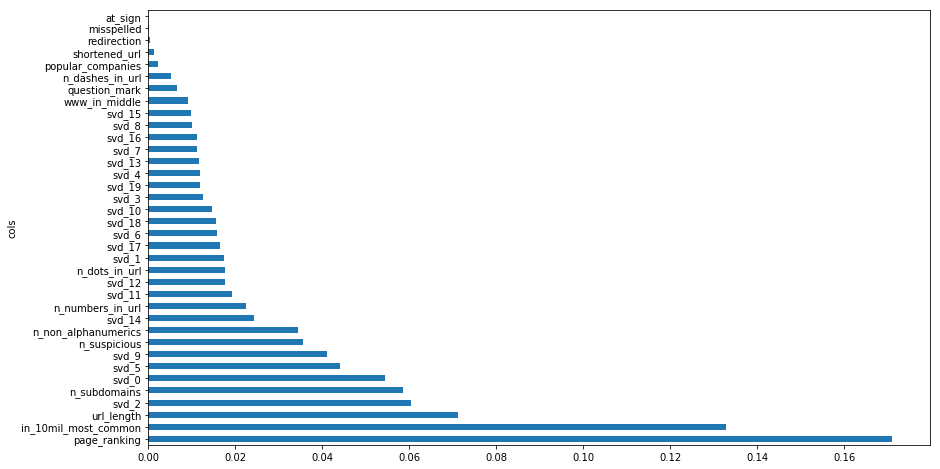

In [54]:
import matplotlib.pyplot as plt
fi = rf_feature_importance(X_train, m)
fi.plot('cols', 'imp', kind='barh', legend=False, figsize=(14,8));

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
y_pred = m.predict(X_valid)

In [47]:
accuracy_score(y_valid, y_pred)

0.9704284089473019

97% WOW!

In the paper they achieved 94.91% accuracy with complex feature engineering using Google trends API, which was not plausible to implement on my 4 core laptop, since the API calls took too much time. Granted our results are not fully comparable as we are using different training and validation sets.

Such a good result almost makes me think that there's something fishy going on with the model.

From the Feature importance plot it seems like some features are not contributing at all. We could drop  these and it could improve perf a tiny bit. I will not do this however as I feel like some of these would be useful in reality, but our dataset is just too narrow and this would be premature optimization.

In [48]:
misspelled = final_data[final_data['misspelled'] == True]

In [49]:
misspelled[misspelled['label'] == 0].shape, misspelled[misspelled['label'] == 1].shape

((54, 38), (184, 38))

Only about 200 misspelled words in 96k this explains why misspelled feature got such a low feature importance. This is probably not the full story since the feature could also be correlated with some other feature that would capture the same information. This would leave to a low feature importance aswell.

### Analyze missclassified instances

Analyzing the domain names of missclassified instances can give us ideas for new features

In [50]:
missclassified = X_valid[y_pred != y_valid].index

In [51]:
missed = final_data.iloc[missclassified]

In [52]:
missed[missed['label'] == 1.0]

,domain,label,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,...,shortened_url,n_subdomains,n_non_alphanumerics,n_suspicious,misspelled,popular_companies,redirection,at_sign,question_mark,www_in_middle
16987,www.properties-us.com/,1.0,0.127701,-0.033119,0.042614,-0.025237,-0.022140,-0.004159,0.005540,-0.003530,...,False,3,4,4,False,False,False,False,False,True
5671,livechat26.volusion.com/livechat.aspx?ID=11805...,1.0,0.000885,-0.000158,0.001137,0.001031,-0.000024,0.006423,-0.000095,0.002703,...,False,15,39,19,False,False,False,False,True,False
4731,ppf.udsu.ru/english/language/itau.atualizar/,1.0,0.001645,-0.000351,0.000707,0.000636,0.003092,0.000804,0.001455,0.000399,...,False,5,7,7,False,False,False,False,False,False
36790,paypal.com.ca.cgi.bin.webscr.cmd.flow.help.wld...,1.0,0.004086,-0.000551,0.024827,0.009327,-0.000666,0.127384,0.041542,-0.038588,...,False,37,69,19,False,True,False,False,True,False
37099,www.sportetambiance.fr/redebay/,1.0,0.105820,-0.027543,-0.009108,-0.016513,-0.013667,-0.000089,0.004126,0.004039,...,False,2,4,4,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10831,www.ipafootcare.org/hayhay.html,1.0,0.736208,0.088293,-0.017745,0.575849,-0.082786,-0.050204,-0.207764,-0.169358,...,False,3,4,4,False,False,False,False,False,True
46782,www.apurvawater.com/.us/?cmd=_home&dispatch=58...,1.0,0.051594,-0.012185,0.068128,0.013502,-0.010591,0.322867,0.096257,-0.120460,...,False,16,46,12,False,False,False,False,True,True
21709,www.xmadwater.com.cn/js?amp,1.0,0.058622,-0.015004,0.044811,-0.011249,-0.013731,0.016607,-0.003732,0.006812,...,False,6,5,5,False,False,False,False,True,True
11464,www4049u.sakura.ne.jp/index.htm,1.0,0.069729,-0.017160,0.035189,0.002817,0.135977,-0.004567,0.031256,0.033033,...,False,7,9,5,False,False,False,False,False,True


These instances were falsely classified as non phising urls.

In [53]:
missed[missed['label'] == 0.0]

,domain,label,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,...,shortened_url,n_subdomains,n_non_alphanumerics,n_suspicious,misspelled,popular_companies,redirection,at_sign,question_mark,www_in_middle
48358,personal.smartt.com/~brianp,0.0,0.000896,-0.000085,0.000268,0.001090,0.001087,0.001046,-0.000139,-0.001085,...,False,2,4,4,False,False,False,False,False,False
50186,home.scarlet.be/~tsh36287/,0.0,0.002405,0.000249,0.002453,0.009511,0.013929,0.010918,-0.000041,-0.017113,...,False,2,10,5,False,False,False,False,False,False
65775,tools.ietf.org/html/rfc2553,0.0,0.233380,0.966478,-0.010184,-0.104539,0.001419,0.005130,0.014978,0.011431,...,False,3,8,4,False,False,False,False,False,False
52733,www.webspawner.com/users/kinneyr/,0.0,0.162418,-0.041753,-0.013055,-0.019748,-0.014777,-0.000518,0.007801,0.006320,...,False,3,5,5,False,False,False,False,False,True
53471,www.aeft.co.kr/English_home1.htm,0.0,0.076124,-0.020081,0.008550,-0.019035,0.111405,0.014047,-0.025934,-0.025289,...,False,7,7,6,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85917,tuxmobil.org/wearables.html,0.0,0.034854,0.043393,0.005587,0.124203,-0.002177,-0.009161,-0.042701,-0.035694,...,False,2,3,3,False,False,False,False,False,False
51799,icefishinglight.homestead.com/higlow.html,0.0,0.228706,0.285034,0.036688,0.814776,-0.014235,-0.060028,-0.280068,-0.234019,...,False,3,4,4,False,False,False,False,False,False
49336,www.freewebs.com/cp-enterprises/,0.0,0.094469,-0.024524,-0.007821,-0.014022,-0.012330,0.002157,0.000904,0.007612,...,False,3,5,5,False,False,False,False,False,True
62752,mathbits.com/MathBits/TISection/Openpage.htm,0.0,0.112853,-0.036533,0.095975,-0.135451,0.897711,0.029805,-0.267354,-0.143056,...,False,4,5,5,False,False,False,False,False,False


These instances were falsely classified as phising urls

Probably not worth to analyze these more at this point...

### Things to do next

Two things pop into my mind:
    1. Test the model on some new dataset.
    
    2. Putting first model into production.
        - This process usually reveals many things that you have not thought of before.
        - Also reveals is this feature of predicting phising urls worth developing more, since you see if it makes the product better. It does not make any sense to spend 5 months developing a sophisticated neural net, and then when going to production you realise that the feature was not even needed and is not worth anything for the users. You could have figured out this fact in the first week with just deploying a simple model first.
        
    3. Getting a larger dataset that represents the range of different kinds of phising attacks better.